In [2]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNetV2
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

In [3]:
model_name='MobileNetV2 10 + 50'
number_of_epochs_0 = 10
number_of_epochs_1 = 50

IMAGE_DIMS = (224,224)

base_model = MobileNetV2(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.


x = base_model.output

#These layers act as output layer for mobilenet but are customed to fit for 6 classes instead of imagenets original 1000.
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dense(1024,activation='relu')(x) #dense layer 2
x = Dense(512,activation='relu')(x) #dense layer 3
preds = Dense(6,activation='softmax')(x) #final layer with softmax activation

model = Model(inputs=base_model.input,outputs=preds)

Instructions for updating:
Colocations handled automatically by placer.


/home/spxylla/anaconda3/envs/dd2424/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:295: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [4]:
datagen = dict(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.13,
        fill_mode='nearest')

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, **datagen)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_directory('./dataset/train',
                                                 target_size=IMAGE_DIMS,
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='training')

validation_generator = train_datagen.flow_from_directory('./dataset/train',
                                                 target_size=IMAGE_DIMS,
                                                 color_mode='rgb',
                                                 batch_size=train_generator.batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation')

test_generator = test_datagen.flow_from_directory('./dataset/test',
                                                 target_size=IMAGE_DIMS,
                                                 color_mode='rgb',
                                                 batch_size=1,
                                                 class_mode='categorical',
                                                 shuffle=False)

Found 1825 images belonging to 6 classes.
Found 271 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


**Initial training of all layers.**

In [5]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train = train_generator.n // train_generator.batch_size
step_size_validation = validation_generator.n // train_generator.batch_size


history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator, 
                   validation_steps = step_size_validation,
                   epochs = number_of_epochs_0)

#Get history of loss and accuracy during training and display it with graphs
train_loss = history.history['loss']
train_acc  = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
57/57 [==============================] - 37s 655ms/step - loss: 1.1437 - acc: 0.5883 - val_loss: 2.7569 - val_acc: 0.4180
Epoch 2/10
57/57 [==============================] - 28s 495ms/step - loss: 0.9404 - acc: 0.6987 - val_loss: 3.0849 - val_acc: 0.4812
Epoch 3/10
57/57 [==============================] - 29s 511ms/step - loss: 0.8373 - acc: 0.7212 - val_loss: 2.5196 - val_acc: 0.4979
Epoch 4/10
57/57 [==============================] - 29s 509ms/step - loss: 0.7192 - acc: 0.7541 - val_loss: 2.1322 - val_acc: 0.5690
Epoch 5/10
57/57 [==============================] - 29s 507ms/step - loss: 0.7773 - acc: 0.7568 - val_loss: 2.6325 - val_acc: 0.5188
Epoch 6/10
57/57 [==============================] - 29s 516ms/step - loss: 0.6557 - acc: 0.7889 - val_loss: 1.5359 - val_acc: 0.6360
Epoch 7/10
57/57 [==============================] - 29s 512ms/step - loss: 0.6093 - acc: 0.7998 - val_loss: 3.0469 - val_acc: 0.4561
Epoch 8/10
57/57 [===

**Freeze all but new layers and train again.**

In [6]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator, 
                   validation_steps = step_size_validation,
                   epochs = number_of_epochs_1)

test_loss, test_acc = model.evaluate_generator(generator=test_generator, steps=test_generator.n)

#Get history of loss and accuracy during training and display it with graphs
train_loss += history.history['loss']
train_acc  += history.history['acc']
val_loss += history.history['val_loss']
val_acc += history.history['val_acc']

Epoch 1/50
57/57 [==============================] - 30s 534ms/step - loss: 0.4630 - acc: 0.8484 - val_loss: 2.3146 - val_acc: 0.4854
Epoch 2/50
57/57 [==============================] - 26s 460ms/step - loss: 0.4405 - acc: 0.8583 - val_loss: 3.8641 - val_acc: 0.4268
Epoch 3/50
57/57 [==============================] - 27s 470ms/step - loss: 0.3926 - acc: 0.8687 - val_loss: 3.3735 - val_acc: 0.4770
Epoch 4/50
57/57 [==============================] - 27s 474ms/step - loss: 0.4316 - acc: 0.8577 - val_loss: 3.2511 - val_acc: 0.4805
Epoch 5/50
57/57 [==============================] - 27s 470ms/step - loss: 0.4432 - acc: 0.8643 - val_loss: 3.2445 - val_acc: 0.4812
Epoch 6/50
57/57 [==============================] - 27s 471ms/step - loss: 0.4109 - acc: 0.8717 - val_loss: 2.9161 - val_acc: 0.5774
Epoch 7/50
57/57 [==============================] - 27s 477ms/step - loss: 0.4305 - acc: 0.8583 - val_loss: 3.3092 - val_acc: 0.5063
Epoch 8/50
57/57 [==============================] - 27s 474ms/step - 

test_loss: 3.780360634062953
test_acc: 0.5266821345707656
A graph displaying the loss over training epochs


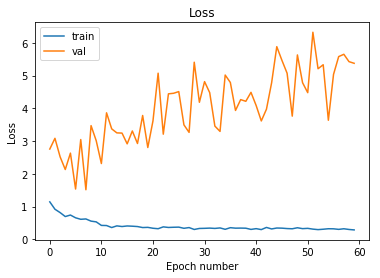

A graph displaying the accuracy over training epochs


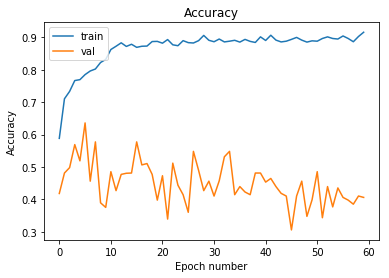

In [7]:
"""
print('train_loss:', train_loss)
print('train_acc:', train_acc)
print('val_loss:', val_loss)
print('val_acc:', val_acc)
"""
print('test_loss:', test_loss)
print('test_acc:', test_acc) 

f= open("test_results.txt","a+")
f.write("____________________________ %s _____________________________ \r\n" % model_name )
f.write("Number of epochs:%d\r\n" % number_of_epochs_1)
f.write("Test Accuracy:%f\r\n" % test_acc)
f.write("Test Loss:%f\r\n" % test_loss)
f.close()

print('A graph displaying the loss over training epochs')
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('graphs/train_loss_' + model_name + '_' + str(number_of_epochs_1) + 'epochs.png')
plt.show()

print('A graph displaying the accuracy over training epochs')
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('graphs/train_acc_' + model_name + '_' + str(number_of_epochs_1) +  'epochs.png')
plt.show()